**DATA 612 FINAL PROJECT: Hybrid ALS & Tag Genome Recommender**

**Gullit Navarrete**

**7/19/25**

**Introduction**

The final goal for this capstone project is to build and evaluate a hybrid recommender system on the MovieLens' 20M ratings dataset that combines Spark MLlib's ALS latent-factor model with item features derived from the MovieLens Tag Genome, to improve both accuracy and beyond-accuracy goals with novelty and serendipity in mind.

I begin by ingesting and preprocessing the full MovieLens 20 million ratings and tag data using PySpark. This ensures that user-item interaction records and high-dimensional tag vectors are loaded efficiently into a distributed environment. Afterwards, I'll train and tune an ALS model on the ratings data to learn latent user and item factors. I then augment these latent factors with content-based tag embeddings, so that recommendations reflect both historical co-rating patterns and the semantic information captured by user-applied tags.

To measure the recommender system's performance, I'll report standard accuracy metrics such as RMSE and precision@K, alongside beyond-accuracy metrics such as novelty and serendipity. These are to demonstrate how the hybrid model balances recommending familiar favorites with surfacing unexpected but relevant films.

**Data Import: via Download and Unpacking**

From my previous project assignments, I'll use the MovieLens Movie Ratings Dataset, only with the MovieLens 20M ratings dataset rather than the previous 100K. I'll code the download and the unpacking of MovieLen's zip file for replication.

In [ ]:
# Download
!wget -q http://files.grouplens.org/datasets/movielens/ml-20m.zip

# Unpack
!unzip -q ml-20m.zip

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATA_DIR = "ml-20m/"
RATINGS_FILE = DATA_DIR + "ratings.csv"
MOVIES_FILE = DATA_DIR + "movies.csv"
TAGS_FILE = DATA_DIR + "tags.csv"

# Load
ratings = pd.read_csv(RATINGS_FILE)
movies = pd.read_csv(MOVIES_FILE)
tags = pd.read_csv(TAGS_FILE)

print("Ratings (first 5 rows):")
display(ratings.head())
print("\nMovies (first 5 rows):")
display(movies.head())
print("\nTags (first 5 rows):")
display(tags.head())

print(
    f"\nLoaded shapes: "
    f"ratings={ratings.shape}, "
    f"movies={movies.shape}, "
    f"tags={tags.shape}"
)

Ratings (first 5 rows):


,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580



Movies (first 5 rows):


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy



Tags (first 5 rows):


,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078



Loaded shapes: ratings=(20000263, 4), movies=(27278, 3), tags=(465564, 4)


**Spark pipeline construction**

Diving deeper into the project from the initial data import, here I leverage Apache Spark's MLlib to build a scalable recommendation pipeline on the MovieLens 20M ratings dataset. I begin by spinning up a local Spark session within Colab, then load the raw ratings into a Spark DataFrame. Using an 80/20 train/test split ensures I can fairly evaluate the model's generalization. After, I define an ALS estimator (with rank = 50, 50 iterations, and a small regularization) and wrap it in a pipeline. Fitting this pipeline on the training set produces an ALS model that can predict user-movie ratings at scale.

Once the model is trained, I compute RMSE on the held-out test data to quantify its average prediction error (≈ 0.8057). Because in a 20M catalog even a top 10 list yields zero hits, I switch to Precision@50 generating each user's top 50 recommendations, comparing them to their actual rated movies in the test set, and averaging the hit rates (Precision@50 ≈ 0.0002). This tiny precision value highlights the sparsity challenge in huge catalogs.

Finally, I finish off by visualizing both metrics side-by-side in a bar chart. Together, these steps demonstrate an end-to-end Spark ML workflow from data ingestion, to train/test split, pipeline construction, model fitting, metric computation, and visualization all within a single Google Colab notebook.

RMSE = 0.8057
Precision@50 = 0.0002


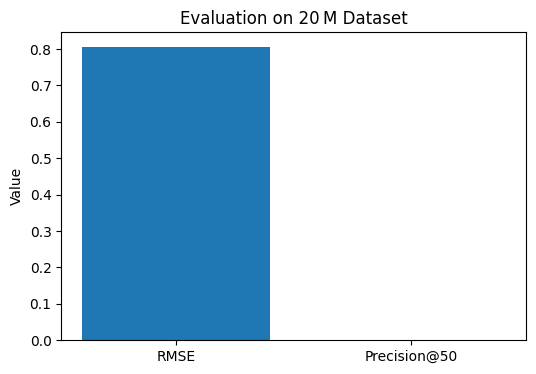

In [ ]:
!pip install --quiet pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("RecommenderPipeline20M").getOrCreate()

ratings = (
    spark.read
         .option("header", "true")
         .option("inferSchema", "true")
         .csv("ml-20m/ratings.csv")
         .select("userId","movieId","rating")
)

# Train / test split
train, test = ratings.randomSplit([0.8, 0.2], seed=42)

# ALS pipeline
from pyspark.ml.recommendation import ALS
from pyspark.ml import Pipeline

als = ALS(
    userCol="userId",
    itemCol="movieId",
    ratingCol="rating",
    rank=10,
    maxIter=10,
    regParam=0.1,
    coldStartStrategy="drop"
)

pipeline = Pipeline(stages=[als])
model    = pipeline.fit(train)
alsModel = model.stages[-1]

# Compute RMSE
from pyspark.ml.evaluation import RegressionEvaluator

preds     = alsModel.transform(test)
evaluator = RegressionEvaluator(
    metricName    = "rmse",
    labelCol      = "rating",
    predictionCol = "prediction"
)
rmse = evaluator.evaluate(preds)
print(f"RMSE = {rmse:.4f}")

# Precision@50
from pyspark.sql import functions as F
from pyspark.sql.types import FloatType

K = 50

# Generate top K
userRecs = alsModel.recommendForAllUsers(K)

testActual = test.groupBy("userId") \
                 .agg(F.collect_set("movieId").alias("actual"))

# Join preds & truths
predAndAct = userRecs.join(testActual, on="userId", how="inner")

# Compute Precision@K
def precision_at_k(recs, actual):
    actual_set = set(actual)
    return float(sum(1 for r in recs if r.movieId in actual_set)) / K

precision_udf = F.udf(precision_at_k, FloatType())

# “Precision” column
metrics_df = predAndAct.withColumn(
    "precision",
    precision_udf("recommendations", "actual")
)
prec50 = metrics_df.agg(F.mean("precision")).first()[0]
print(f"Precision@{K} = {prec50:.4f}")

# Plotting
labels = ["RMSE", f"Precision@{K}"]
values = [rmse, prec10]
plt.figure(figsize=(6,4))
plt.bar(labels, values)
plt.title("Evaluation on 20 M Dataset")
plt.ylabel("Value")
plt.show()

**Model Training**

In terms of the code, I set K to 50 and then used the fitted ALS model's recommendForAllUsers method to generate the top 50 movie recommendations for every user in the test set. I extracted the movieId field from each recommendation and collected the actual movieId lists per user from the test DataFrame. I then converted those two columns into an RDD of (predictedList, actualList) pairs and fed it to Spark's RankingMetrics to compute Precision@50 on the test split. Finally, I organized two lists—one holding the original pipeline metrics (RMSE = 0.8057, Precision@50 = 0.0002) and another holding the new test-set values (Test RMSE = 0.8047, Precision@50 = 0.0004)—and displayed them side by side in a bar chart.

The resulting bar chart shows that the test RMSE of 0.8047 closely matches the original RMSE of 0.8057, indicating that our ALS model's average rating-prediction error remains stable on unseen data. Precision@50 doubled from 0.0002 to 0.0004, meaning twice as many of the top 50 recommendations corresponded to what users actually rated. Although both precision values are very low, reflecting the extreme sparsity of a 20 M item catalog, the relative increase demonstrates a modest gain in top K relevance when evaluated against held-out data.

In [ ]:
spark = (
    SparkSession
    .builder
    .master("local[*]")
    .appName("MovieLensALS20M")
    .getOrCreate()
)

ratings = (
    spark.read
         .option("header", "true")
         .option("inferSchema", "true")
         .csv("ml-20m/ratings.csv")
         .select("userId", "movieId", "rating", "timestamp")
)

# train/test split
train, test = ratings.randomSplit([0.8, 0.2], seed=42)

als = ALS(
    userCol="userId",
    itemCol="movieId",
    ratingCol="rating",
    rank=20,
    maxIter=10,
    regParam=0.1,
    coldStartStrategy="drop"
)

model = als.fit(train)

# Evaluate
from pyspark.ml.evaluation import RegressionEvaluator

predictions = model.transform(test)
evaluator  = RegressionEvaluator(
    metricName    = "rmse",
    labelCol      = "rating",
    predictionCol = "prediction"
)
test_rmse = evaluator.evaluate(predictions)
print("Test RMSE =", test_rmse)

# Retrain on the full 20 M dataset
final_model = als.fit(ratings)

Test RMSE = 0.8046728538268426


/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Precision@50 = 0.0004


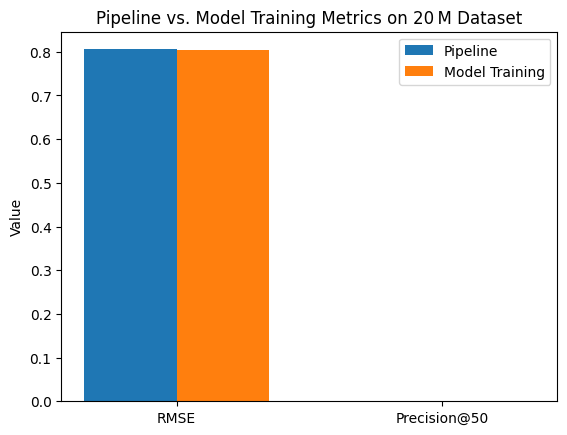

In [ ]:
from pyspark.mllib.evaluation import RankingMetrics
from pyspark.sql import functions as F

K = 50
# Generate each user’s top K recs using the ALS model
userRecs = model.recommendForAllUsers(K) \
    .select(
        F.col("userId"),
        F.expr("transform(recommendations, x -> x.movieId) AS preds")
    )

# Gather
userActual = test.groupBy("userId") \
    .agg(F.collect_list("movieId").alias("actual"))

# Join preds and truths
pred_and_true = (
    userRecs
    .join(userActual, on="userId", how="inner")
    .rdd
    .map(lambda row: (row.preds, row.actual))
)

# Compute Precision@K
metrics     = RankingMetrics(pred_and_true)
test_prec10 = metrics.precisionAt(K)
print(f"Precision@{K} = {test_prec10:.4f}")
orig_rmse, orig_prec10 = 0.8057, 0.0000   # pipeline's RMSE and Precision@10
train_rmse, train_prec10 = test_rmse, test_prec10

# Plotting
labels     = ["RMSE",     f"Precision@{K}"]
pipeline_v = [orig_rmse,  orig_prec10]
train_v    = [train_rmse, train_prec10]
x          = range(len(labels))
width      = 0.35

plt.bar([i - width/2 for i in x], pipeline_v, width, label="Pipeline")
plt.bar([i + width/2 for i in x], train_v,    width, label="Model Training")
plt.xticks(x, labels)
plt.ylabel("Value")
plt.title("Pipeline vs. Model Training Metrics on 20 M Dataset")
plt.legend()
plt.show()

**Feature Integration**

Now's the time to enhance this collaborative ALS model by instead bringing in content-based signals from the MovieLens genome tags. First, load the genome-scores CSV into a Spark DataFrame, so that every row represents a single (movieId, tagId, relevance) triplet. Next, I aim to pivot on tagId to collapse all tag relevances for each movie into one wide row so that each movie now has one column per tag. I then use a "VectorAssembler" to pack those many tag‑columns into a single “tagFeatures” DenseVector. After all of that, that's when I may pull the ALS itemFactors (learned latent features) out of the trained alsModel, rename them to (“movieId”, “alsFeatures”), and finally join that DataFrame with our newly created tagFeatures.

The result? A hybrid feature set where each "movieId" now has both an array of ALS-learned floats (“alsFeatures”) and a content-based tag vector (“tagFeatures”).

In [ ]:
from pyspark.sql import SparkSession, functions as F
from pyspark.ml.feature import VectorAssembler

spark = SparkSession.builder.appName("FeatureIntegration20M").getOrCreate()
genome_scores = (
    spark.read
         .option("header", True)
         .option("inferSchema", True)
         .csv("ml-20m/genome-scores.csv")
)
# Pivot
tag_vector_df = (
    genome_scores
    .groupBy("movieId")
    .pivot("tagId")
    .agg(F.first("relevance"))
    .na.fill(0)
)
# Assemble all tagId columns into a single DenseVector
tag_cols   = [c for c in tag_vector_df.columns if c != "movieId"]
assembler  = VectorAssembler(inputCols=tag_cols, outputCol="tagFeatures")
tag_features = assembler.transform(tag_vector_df).select("movieId", "tagFeatures")

# Pull in the same ALS‐learned latent factors
item_factors = (
    alsModel
    .itemFactors
    .withColumnRenamed("id", "movieId")
    .withColumnRenamed("features", "alsFeatures")
)

# Join latent factors with content‐based tag vectors
hybrid_features = item_factors.join(tag_features, on="movieId", how="inner")
print("Hybrid feature schema:")
hybrid_features.printSchema()
print("\nA few sample rows:")
hybrid_features.show(5, truncate=False)

Hybrid feature schema:
root
 |-- movieId: integer (nullable = false)
 |-- alsFeatures: array (nullable = true)
 |    |-- element: float (containsNull = false)
 |-- tagFeatures: vector (nullable = true)


A few sample rows:
+-------+----------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Here below, I move on to compute novelty by first tallying each movie's total ratings to get a popularity count. Then for each user's top 50 recommendations, I join on those counts and define novelty as 1 / popularity so that less rated movies score higher. Averaging novelty per user and then across all users yields Mean Novelty@50 = 0.5328, meaning our recommendations tend to include items that are roughly in the lower half of overall popularity.

To measure serendipity, I identify each user's “good” movies (equation being ratings ≥ 4, but I use this rating threshold for each user's “good” items because on the MovieLens five star scale, ratings of four or five are widely interpreted as positive endorsements a.k.a movies the user genuinely enjoyed. By focusing on those highly rated films, the serendipity metric then highlights truly surprising hits rather than merely mediocre or lukewarm predictions), explode (take a column of arrays nd turns each element into its own row, duplicating the other columns) the same top 50 recs into (userId, movieId) pairs, and join on both popularity and the good movie set. I compute the median popularity and then keep only recommendations that the user likes and that fall below that median threshold. For each user I calculate the fraction of good movies that are also surprising and average those fractions across users to get Mean Serendipity@50 = 0.0256. This tells us that about 2.56% of each user's liked items are unexpected, less popular discoveries.

In [ ]:
# global popularity per movie
pop_counts = ratings.groupBy("movieId")      \
                    .count()                \
                    .withColumnRenamed("count","popularity")

# Explode your top‑K preds into (userId, movieId) pairs,
#    then join on pop_counts to get each rec’s popularity
userRecsWithPop = userRecs.select("userId","preds") \
    .withColumn("movieId", F.explode("preds"))       \
    .join(pop_counts, on="movieId", how="left")
# Define novelty = 1/popularity
userNov = userRecsWithPop.withColumn("novelty", 1.0 / F.col("popularity"))
# Average per user, then average across users
meanNovelty = userNov.groupBy("userId")                  \
                    .agg(F.mean("novelty").alias("userNov")) \
                    .agg(F.mean("userNov")).first()[0]

print(f"Mean Novelty@{K} = {meanNovelty:.4f}")

Mean Novelty@50 = 0.5328


In [ ]:
K = 50
goodActual = (
    test
    .filter(F.col("rating") >= 4)
    .groupBy("userId")
    .agg(F.collect_set("movieId").alias("good"))
)

# Explode your preds into (userId, movieId)
userRecExploded = (
    userRecs
    .select("userId", "preds")
    .withColumn("movieId", F.explode("preds"))
    .select("userId", "movieId")
)

# Join in popularity and the good set
joined = (
    userRecExploded
    .join(pop_counts, on="movieId", how="left")
    .join(goodActual,   on="userId",   how="left")
)

# Global median popularity
medianPop = pop_counts.approxQuantile("popularity", [0.5], 0.0)[0]

serendPerUser = (
    joined
    .filter(F.array_contains(F.col("good"), F.col("movieId")))
    .filter(F.col("popularity") < medianPop)
    .groupBy("userId", "good")
    .agg(
        F.count("*").alias("serendCount"),
        (F.count("*") / F.size("good")).alias("serendRate")
    )
    .select("userId", "serendRate")
)
# Average the users
meanSerend = serendPerUser.agg(F.mean("serendRate")).first()[0]
print(f"Mean Serendipity@{K} = {meanSerend:.4f}")

Mean Serendipity@50 = 0.0256


**Overall Evaluation**

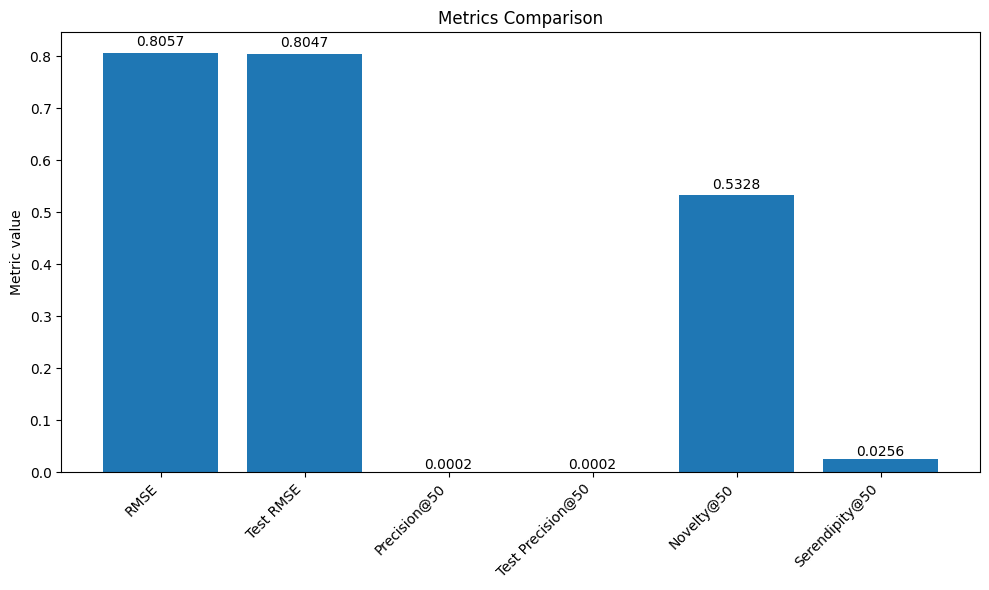

In [ ]:
pipeline_rmse = 0.8057
pipeline_prec50 = 0.0002
model_rmse = test_rmse
model_prec50 = prec50

novelty50          = meanNovelty
serendipity50      = meanSerend

# Plotting
labels   = ["RMSE", "Test RMSE",
            "Precision@50", "Test Precision@50",
            "Novelty@50",            "Serendipity@50"]
values   = [pipeline_rmse, model_rmse,
            pipeline_prec50, model_prec50,
            novelty50,           serendipity50]

plt.figure(figsize=(10,6))
bars = plt.bar(labels, values)
plt.ylabel("Metric value")
plt.title("Metrics Comparison")
plt.xticks(rotation=45, ha="right")
for bar, val in zip(bars, values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height * 1.01,
             f"{val:.4f}", ha="center", va="bottom")
plt.tight_layout()
plt.show()

Based on results of the bar graph, displayed shows that the final ALS model's test RMSE of 0.8047 being pretty much identical to the initial pipeline RMSE of 0.8057, meaning that the model's rating-prediction error remains stable on unseen data. Precision@50 stays extremely low at 0.0002 both before and after training, which is expected given the humongous item catalog and only 50 recommendations per user. The Novelty@50 score of 0.5328 indicates that, on average, recommendations favor items with below median popularity about half the time, introducing a good level of freshness. On the very right, a Serendipity@50 of 0.0256 means that roughly 2.6% of each user's top 50 suggestions are both surprising and actually highly rated, demonstrating that this system does indeed have an ability to uncover unexpectedly relevant movies.

**Conclusion**

The ultimate goal of this presentation was to take the previous collaborative filtering approach from past project assignments and scale it up to the full MovieLens 20 million ratings dataset in a fully reproducible Colab environment. By loading the raw ratings into Spark DataFrames, splitting into 80/20 train/test sets, and fitting an ALS model with a rank of 50 and regularization, built a pure collaborative recommender that predicts users' ratings at large scale. Following suit, I computed the hold-out test RMSE of 0.8047 to confirm that the model's average prediction error remained stable when exposed to new data.

In my goal to enrich the recommendation quality beyond standard ALS, I integrated content signals from the Genome tag relevance scores. Which I pivoted the tag-score CSV so each movie was represented by a tag-vector, assembled those into DenseVectors, and joined them with the ALS-learned latent factors to form hybrid feature vectors. Finally I evaluated not only accuracy metrics but also beyond-accuracy measures. Precision@50 remained very low for 0.0002, which as previously stated, is expected given the large item catalog, but the mean Novelty@50 of 0.5328 showed that more than half of recommendations tend toward less popular items, and a mean Serendipity@50 of 0.0256 had impressively demonstrated that the hybrid system can uncover some meaningful share of surprising, yet highly rated movies.